In [1]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load dataset
df=pd.read_csv("Fraud.csv")
df.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0

In [3]:
df.tail()

step      type      amount     nameOrig  oldbalanceOrg  \
6362615   743  CASH_OUT   339682.13   C786484425      339682.13   
6362616   743  TRANSFER  6311409.28  C1529008245     6311409.28   
6362617   743  CASH_OUT  6311409.28  C1162922333     6311409.28   
6362618   743  TRANSFER   850002.52  C1685995037      850002.52   
6362619   743  CASH_OUT   850002.52  C1280323807      850002.52   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
6362615             0.0   C776919290            0.00       339682.13        1   
6362616             0.0  C1881841831            0.00            0.00        1   
6362617             0.0  C1365125890        68488.84      6379898.11        1   
6362618             0.0  C2080388513            0.00            0.00        1   
6362619             0.0   C873221189      6510099.11      7360101.63        1   

         isFlaggedFraud  
6362615               0  
6362616               0  
6362617               0  
6362618               0  
6362619               0

In [4]:
df.shape

(6362620, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## Data Cleaning

In [6]:
print(df.isnull().sum()) # missing values 

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [7]:
print(df.drop_duplicates(inplace=True)) # Duplicate values

None


In [8]:
print(df.describe()) # Statistics

               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.000000e+00    0.000000e+00

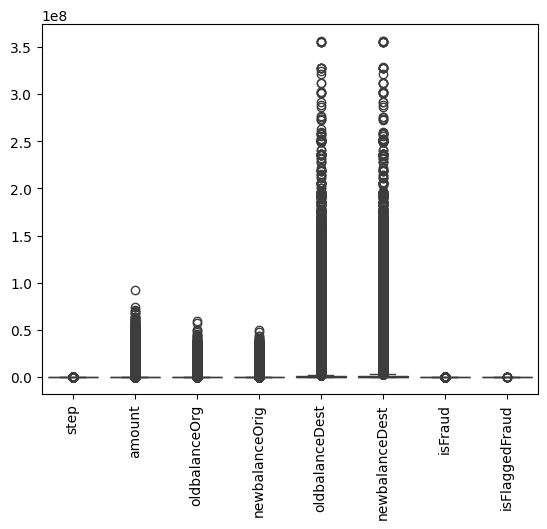

In [9]:
# Outliers

sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()

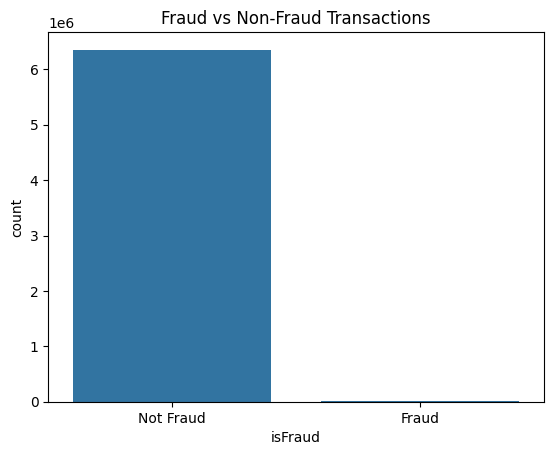

isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64


In [10]:
sns.countplot(x='isFraud', data=df)
plt.title("Fraud vs Non-Fraud Transactions")
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.show()

print(df['isFraud'].value_counts(normalize=True) * 100)


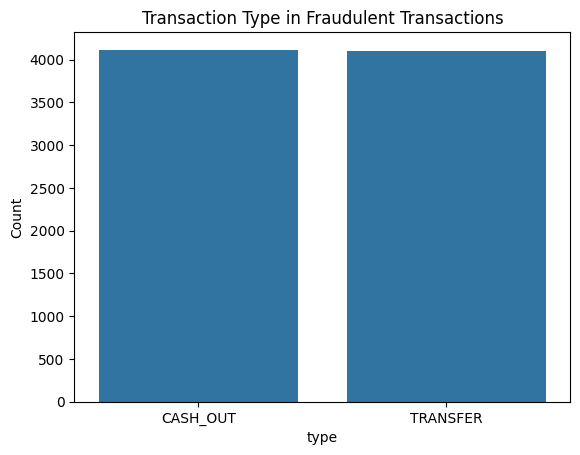

In [11]:
fraud_by_type = df[df['isFraud'] == 1]['type'].value_counts()
sns.barplot(x=fraud_by_type.index, y=fraud_by_type.values)
plt.title("Transaction Type in Fraudulent Transactions")
plt.ylabel("Count")
plt.show()


In [12]:
#Multicolinearity 
#compute VIF for numeric features
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor

X=df.select_dtypes(include=np.number)
vif=pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

          feature         VIF
0            step    1.191094
1          amount    4.078952
2   oldbalanceOrg  544.053103
3  newbalanceOrig  546.346008
4  oldbalanceDest   72.895522
5  newbalanceDest   84.584619
6         isFraud    1.188386
7  isFlaggedFraud    1.002546


In [13]:
# Select categorical columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns
print("Categorical Columns:", cat_cols.tolist())

Categorical Columns: ['type', 'nameOrig', 'nameDest']


In [14]:
# One-hot encode 'type'
df = pd.get_dummies(df, columns=['type'], drop_first=True)

# Frequency encode IDs
df['nameOrig_freq'] = df['nameOrig'].map(df['nameOrig'].value_counts())
df['nameDest_freq'] = df['nameDest'].map(df['nameDest'].value_counts())

# Drop original ID columns (to avoid data leakage)
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)


In [15]:
print(df.columns.tolist())


['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', 'nameOrig_freq', 'nameDest_freq']


In [16]:
# Drop isFlaggedFraud (not useful, almost always 0)
X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [18]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)

# Random Forest
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train_scaled, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

Logistic Regression:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.92      0.41      0.56      1643

    accuracy                           1.00   1272524
   macro avg       0.96      0.70      0.78   1272524
weighted avg       1.00      1.00      1.00   1272524

Random Forest:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.98      0.77      0.86      1643

    accuracy                           1.00   1272524
   macro avg       0.99      0.88      0.93   1272524
weighted avg       1.00      1.00      1.00   1272524



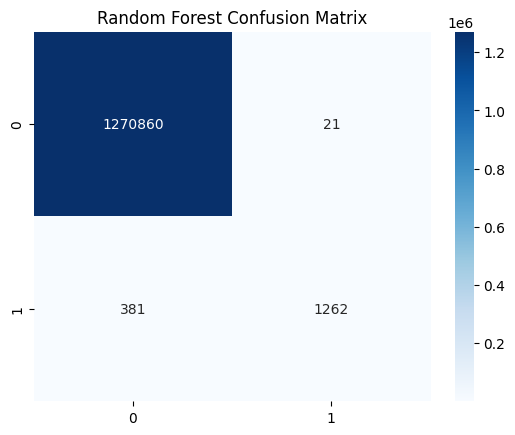

In [19]:
# Predictions
y_pred_lr = lr.predict(X_test_scaled)
y_pred_rf = rf.predict(X_test_scaled)

# Reports
print("Logistic Regression:\n", classification_report(y_test, y_pred_lr))
print("Random Forest:\n", classification_report(y_test, y_pred_rf))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

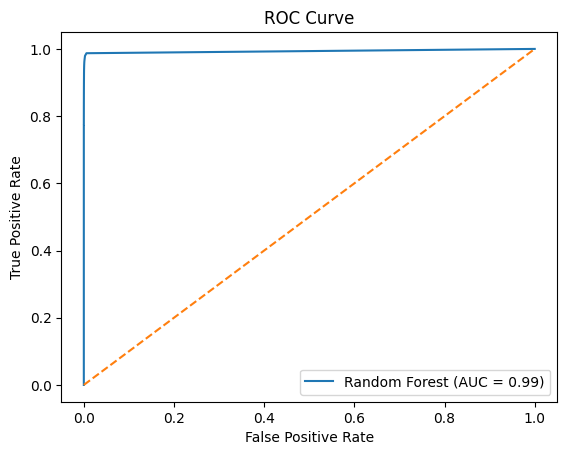

In [20]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test_scaled)[:, 1])
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc_score(y_test, rf.predict_proba(X_test_scaled)[:, 1]):.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


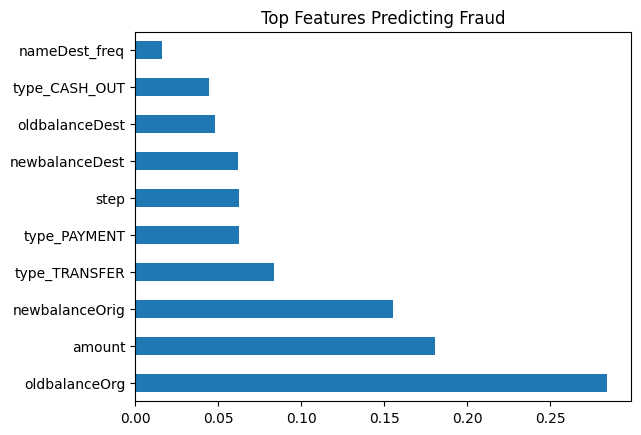

In [21]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')
plt.title("Top Features Predicting Fraud")
plt.show()


In [22]:
import joblib

# Save the trained model and scaler
joblib.dump(rf, "fraud_rf_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [23]:
import streamlit as st
import joblib
import numpy as np
import pandas as pd

# Load model and scaler
model = joblib.load("fraud_rf_model.pkl")
scaler = joblib.load("scaler.pkl")

# Define the order of features
FEATURES = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
            'oldbalanceDest', 'newbalanceDest',
            'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER',
            'nameOrig_freq', 'nameDest_freq']

# Page title
st.title(" Fraud Transaction Detection App")
st.markdown("Enter transaction details to check if it's fraudulent.")

# Input fields
step = st.number_input("Step (time in hours)", value=1)
amount = st.number_input("Amount", value=1000.0)
oldbalanceOrg = st.number_input("Old Balance (Origin)", value=5000.0)
newbalanceOrig = st.number_input("New Balance (Origin)", value=4000.0)
oldbalanceDest = st.number_input("Old Balance (Destination)", value=0.0)
newbalanceDest = st.number_input("New Balance (Destination)", value=1000.0)

# Transaction type
txn_type = st.selectbox("Transaction Type", ['CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER'])

# Dummy encode the type
type_CASH_OUT = 1 if txn_type == 'CASH_OUT' else 0
type_DEBIT = 1 if txn_type == 'DEBIT' else 0
type_PAYMENT = 1 if txn_type == 'PAYMENT' else 0
type_TRANSFER = 1 if txn_type == 'TRANSFER' else 0

# Frequency inputs
nameOrig_freq = st.number_input("Origin Account Frequency", value=10)
nameDest_freq = st.number_input("Destination Account Frequency", value=20)

# Prepare input array
input_data = pd.DataFrame([[
    step, amount, oldbalanceOrg, newbalanceOrig,
    oldbalanceDest, newbalanceDest,
    type_CASH_OUT, type_DEBIT, type_PAYMENT, type_TRANSFER,
    nameOrig_freq, nameDest_freq
]], columns=FEATURES)

# Scale input
scaled_input = scaler.transform(input_data)

# Prediction
if st.button("Predict"):
    prediction = model.predict(scaled_input)[0]
    probability = model.predict_proba(scaled_input)[0][1]

    if prediction == 1:
        st.error(f"This transaction is predicted as **FRAUD** (Probability: {probability:.2f})")
    else:
        st.success(f" This transaction is **NOT Fraudulent** (Probability: {probability:.2f})")


2025-07-29 17:13:47.865 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-29 17:13:50.800 
  command:

    streamlit run C:\Users\kavya\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-07-29 17:13:50.816 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-29 17:13:50.816 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-29 17:13:50.816 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-29 17:13:50.816 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-29 17:13:50.816 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-29 17:13: